In [39]:
%matplotlib inline
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from mpld3 import fig_to_html, plugins
from datetime import datetime
import statsmodels.api as sm
from pandas.tseries.offsets import *
import seaborn as sns
import boto

from pyspark import SparkContext, SQLContext
from statsmodels.tsa.arima_model import ARIMA
from pyspark.sql.functions import *
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, TimestampType, DoubleType, StringType

from sparkts.datetimeindex import uniform, BusinessDayFrequency
from sparkts.timeseriesrdd import time_series_rdd_from_observations

In [2]:
#get raw data
raw_yahoo_finance = spark.read.json("s3a://yahoo-data-final-project/2017/03/*/*")

In [3]:
#check the data
raw_yahoo_finance.show(2)

+----------+----------+----------+----------+----------+----------+------+-------+----+----+----+----+----+----+----+
| Adj_Close|     Close|      Date|      High|       Low|      Open|Symbol| Volume|col0|col1|col2|col3|col4|col5|col6|
+----------+----------+----------+----------+----------+----------+------+-------+----+----+----+----+----+----+----+
|300.860874|601.120027|2009-12-22|601.500017|598.850021|601.340021| googl|3757800|null|null|null|null|null|null|null|
|306.146153|611.680013|2009-12-23|612.869984|602.849985| 603.50003| googl|4141200|null|null|null|null|null|null|null|
+----------+----------+----------+----------+----------+----------+------+-------+----+----+----+----+----+----+----+
only showing top 2 rows



In [4]:
#check schema of the data
raw_yahoo_finance.printSchema()

root
 |-- Adj_Close: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- col0: string (nullable = true)
 |-- col1: string (nullable = true)
 |-- col2: string (nullable = true)
 |-- col3: string (nullable = true)
 |-- col4: string (nullable = true)
 |-- col5: string (nullable = true)
 |-- col6: string (nullable = true)



In [5]:
#take off NULL and cache
raw_yahoo_finance = raw_yahoo_finance.filter('Adj_Close IS NOT NULL')
raw_yahoo_finance.cache()

DataFrame[Adj_Close: string, Close: string, Date: string, High: string, Low: string, Open: string, Symbol: string, Volume: string, col0: string, col1: string, col2: string, col3: string, col4: string, col5: string, col6: string]

In [6]:
raw_yahoo_finance.toPandas()['Symbol'].unique()

array([u'googl', u'aapl', u'AMZN', u'msft'], dtype=object)

In [7]:
'''
AAPL: Apple
MSFT: Microsoft
NFLX: NetFlix 
AMZN: Amazon
JPM: JP Morgan
DX-Y.NYB: Dallar Index
CNY%3dX: USD/CNY
BAC: Bank of America
GOOGL: Google
'''

'\nAAPL: Apple\nMSFT: Microsoft\nNFLX: NetFlix \nAMZN: Amazon\nJPM: JP Morgan\nDX-Y.NYB: Dallar Index\nCNY%3dX: USD/CNY\nBAC: Bank of America\nGOOGL: Google\n'

In [13]:
import EMR_update_current

In [10]:
'''
run EMR_updata_current.py in EMR with cronjob
every day at 6AM, it will over write(store) into S3 as parquet(yahoo-symbol-price/yahoo-price-parquet).
'''
def update_current():
    '''
    INPUT: S3 stored data.
    OUTPUT: updated current price for each symbols, then over write into S3 as parquet.
    '''
    raw_yahoo_finance = spark.read.json("s3a://yahoo-data-final-project/2017/03/*/*")
    yahoo_price_df = raw_yahoo_finance.selectExpr("Adj_Close AS price", 
                                                  "Date AS date",
                                                  "Symbol")
    yahoo_price_df.write.mode('overwrite').parquet("s3a://yahoo-symbol-price/yahoo-price-parquet")
    #apple stock
    #symbol = yahoo_price_df.selectExpr("price", "Date AS date").where(yahoo_price_df.Symbol == 'aapl')
    #symbol.write.mode('overwrite').parquet("s3a://yahoo-symbol-price/apple")
    
    
    apple = yahoo_price_df.selectExpr("price", "Date AS date").where(yahoo_price_df.Symbol == 'aapl')
    apple.write.mode('overwrite').parquet("s3a://yahoo-symbol-price/apple")
    
    msft = yahoo_price_df.selectExpr("price", "Date AS date").where(yahoo_price_df.Symbol == 'msft')
    msft.write.mode('overwrite').parquet("s3a://yahoo-symbol-price/msft")
    
    amzn = yahoo_price_df.selectExpr("price", "Date AS date").where(yahoo_price_df.Symbol == 'AMZN')
    amzn.write.mode('overwrite').parquet("s3a://yahoo-symbol-price/amzn")
    
    googl = yahoo_price_df.selectExpr("price", "Date AS date").where(yahoo_price_df.Symbol == 'googl')
    googl.write.mode('overwrite').parquet("s3a://yahoo-symbol-price/googl")
    
    jpm = yahoo_price_df.selectExpr("price", "Date AS date").where(yahoo_price_df.Symbol == 'JPM')
    jpm.write.mode('overwrite').parquet("s3a://yahoo-symbol-price/jpm")

    bac = yahoo_price_df.selectExpr("price", "Date AS date").where(yahoo_price_df.Symbol == 'BAC')
    bac.write.mode('overwrite').parquet("s3a://yahoo-symbol-price/bac")

In [11]:
#call the update fuction
update_current()

In [14]:
#load parquet files for each symbol
aapl_df = spark.read.load("s3a://yahoo-symbol-price/apple")
msft_df = spark.read.load("s3a://yahoo-symbol-price/msft")
amzn_df = spark.read.load("s3a://yahoo-symbol-price/amzn")
googl_df = spark.read.load("s3a://yahoo-symbol-price/googl")
#jpm_df = spark.read.load("s3a://yahoo-symbol-price/jpm")
#bac_df = spark.read.load("s3a://yahoo-symbol-price/bac")

In [15]:
#count number of data
print(aapl_df.agg(count("date").alias('c')).collect())
print(msft_df.agg(count("date").alias('c')).collect())
print(amzn_df.agg(count("date").alias('c')).collect())
print(googl_df.agg(count("date").alias('c')).collect())
#print(jpm_df.agg(count("date").alias('c')).collect())
#print(bac_df.agg(count("date").alias('c')).collect())

[Row(c=2516)]
[Row(c=2513)]
[Row(c=2515)]
[Row(c=2532)]


In [16]:
#trasfer into pandas
aapl_pd = aapl_df.toPandas().drop_duplicates('date')

In [17]:
msft_pd = msft_df.toPandas().drop_duplicates('date')

In [18]:
amzn_pd = amzn_df.toPandas().drop_duplicates('date')

In [19]:
googl_pd = googl_df.toPandas().drop_duplicates('date')

In [20]:
#date as index for every symbol
aapl_pd.index = aapl_pd['date']
aapl_pd = aapl_pd.drop('date', axis=1)
aapl_pd.columns = ['aapl']

In [21]:
msft_pd.index = msft_pd['date']
msft_pd = msft_pd.drop('date', axis=1)
msft_pd.columns = ['msft']

In [22]:
amzn_pd.index = amzn_pd['date']
amzn_pd = amzn_pd.drop('date', axis=1)
amzn_pd.columns = ['amzn']

In [23]:
googl_pd.index = googl_pd['date']
googl_pd = googl_pd.drop('date', axis=1)
googl_pd.columns = ['googl']

In [24]:
#all dateframe concat to compare
price_df = pd.concat([aapl_pd, msft_pd, amzn_pd, googl_pd], join='outer', axis = 1).dropna(axis=0)

In [25]:
price_df = price_df.reset_index()

In [26]:
price_df['date'] = price_df['index'].convert_objects(convert_dates='coerce')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [27]:
price_df = price_df.drop('index', axis=1)

In [28]:
price_df.head(3)

,aapl,msft,amzn,googl,date
0,11.643517,21.519958,38.810001,227.602603,2007-03-12
1,11.453064,20.955294,37.82,221.736743,2007-03-13
2,11.660359,21.488587,38.080002,224.224231,2007-03-14


In [29]:
price_df.tail(3)

,aapl,msft,amzn,googl,date
2508,139.779999,64.25,849.880005,849.080017,2017-03-03
2509,139.339996,64.269997,846.609985,847.27002,2017-03-06
2510,139.520004,64.400002,846.02002,851.150024,2017-03-07


In [30]:
price_df = price_df.sort_index(by='date')  
price_df = price_df.set_index('date') 

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


In [31]:
price_df.head(5)

,aapl,msft,amzn,googl
date,,,,
2007-03-12,11.643517,21.519958,38.810001,227.602603
2007-03-13,11.453064,20.955294,37.82,221.736743
2007-03-14,11.660359,21.488587,38.080002,224.224231
2007-03-15,11.604649,21.394478,37.779999,223.318316
2007-03-16,11.60724,21.43369,37.849998,220.645648


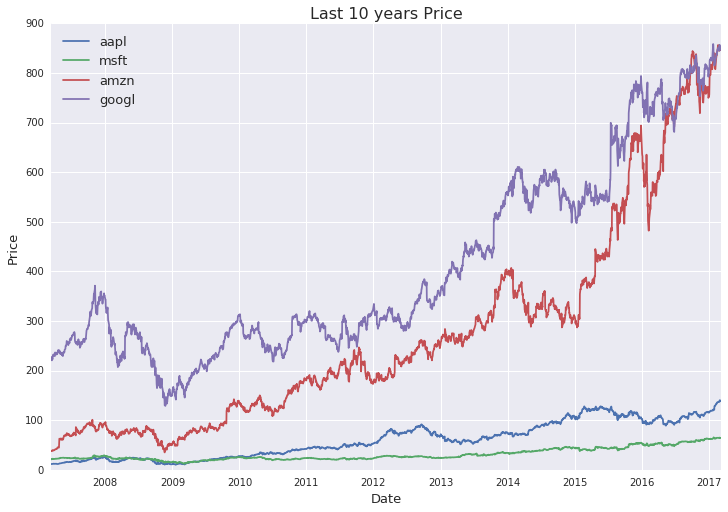

In [32]:
plt.figure(figsize=(12, 8))
plt.title("Last 10 years Price", fontsize=16)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Price", fontsize=13)
plt.plot(price_df)
plt.legend(price_df.columns, fontsize=13, loc=2);

In [33]:
price_std60 = pd.rolling_std(price_df, 60, min_periods=10)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=10,window=60,center=False).std()
  if __name__ == '__main__':


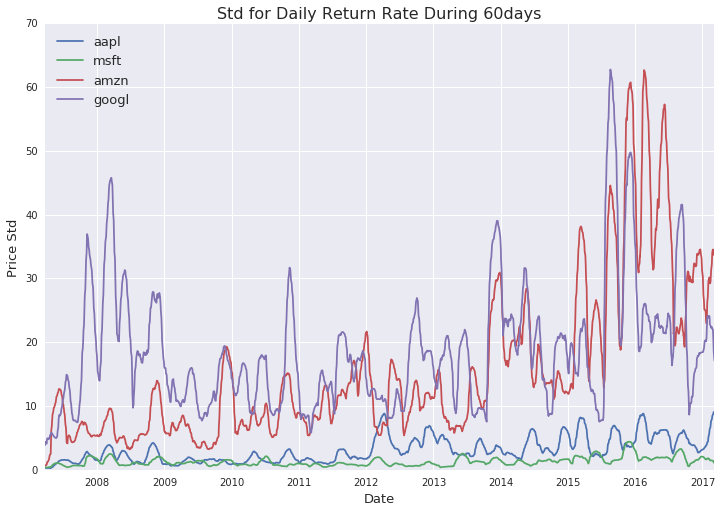

In [34]:
plt.figure(figsize=(12, 8))
plt.title("Std for Daily Return Rate During 60days", fontsize=16)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Price Std", fontsize=13)
plt.plot(price_std60)
plt.legend(price_df.columns, fontsize=13, loc=2);

In [35]:
corr_ap_ms = pd.rolling_corr(price_df.aapl, price_df.msft, 30, min_periods=30).dropna(axis=0)
corr_az_gl = pd.rolling_corr(price_df.amzn, price_df.googl, 30, min_periods=30).dropna(axis=0)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30).corr(other=<Series>)
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30).corr(other=<Series>)
  from ipykernel import kernelapp as app


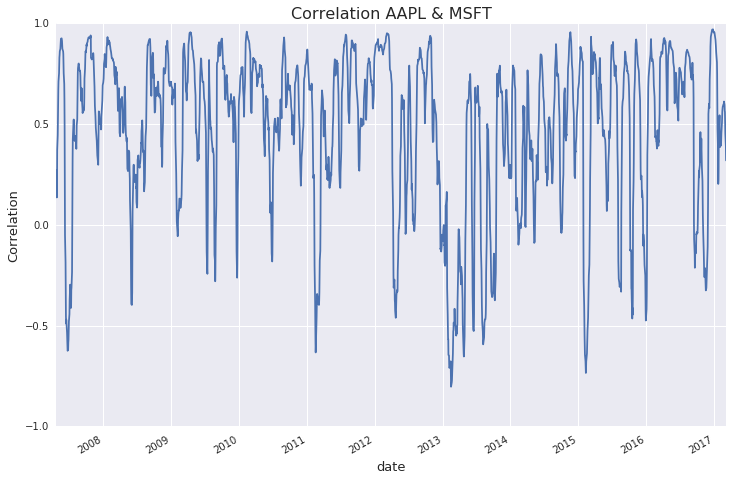

In [44]:
fig1 = plt.figure(figsize=(12, 8))
plt.title("Correlation AAPL & MSFT", fontsize=16)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Correlation", fontsize=13)
corr_ap_ms.plot();
fig1.savefig('AAPL_MSFT.png')

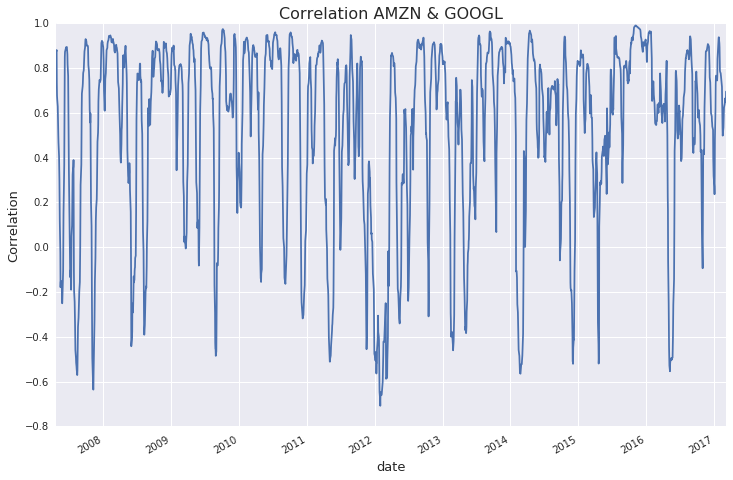

In [45]:
fig2 = plt.figure(figsize=(12, 8))
plt.title("Correlation AMZN & GOOGL", fontsize=16)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Correlation", fontsize=13)
corr_az_gl.plot();
fig2.savefig('AMZN_GOOGL.png')

In [40]:
#AWS
conn = boto.connect_s3(host='s3.amazonaws.com')
conn.get_all_buckets()

[<Bucket: 4-1-lab-yun-tracy>,
 <Bucket: aws-logs-463996866259-us-east-1>,
 <Bucket: mrjob-ec7c2a741ae69ec1>,
 <Bucket: twitter-spark>,
 <Bucket: www.yun>,
 <Bucket: yahoo-data-final-project>,
 <Bucket: yahoo-symbol-price>,
 <Bucket: yun-hadoop>,
 <Bucket: yun-spark>,
 <Bucket: yun.bucket01>,
 <Bucket: yun.com>]

In [41]:
website_bucket = conn.get_bucket('yahoo-symbol-price')

In [50]:
corr1 = "AAPL_MSFT.png"
corr1 = "<!DOCTYPE html>\
            <html>\
              <body>\
                <h2>Correlation</h2>\
                  <img src=http://ec2-54-234-234-93.compute-1.amazonaws.com:8888/files/{} style='width:500px;height:350px;'>\
              </body>\
            </html>".format(corr1)
output_file = website_bucket.new_key('corr1.html')
output_file.content_type = 'text/html'
output_file.set_contents_from_string(corr1, policy='public-read')

264

In [51]:
corr2 = "AMZN_GOOGL.png"
corr2 = "<!DOCTYPE html>\
            <html>\
              <body>\
                <h2>Correlation</h2>\
                  <img src=http://ec2-54-234-234-93.compute-1.amazonaws.com:8888/files/{} style='width:500px;height:350px;'>\
              </body>\
            </html>".format(corr2)
output_file = website_bucket.new_key('corr2.html')
output_file.content_type = 'text/html'
output_file.set_contents_from_string(corr2, policy='public-read')

265